In [1]:
import os
from astropy.io import fits
from astropy.table import Table
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import Gaussian2DKernel, convolve, convolve_fft, interpolate_replace_nans
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from scipy.ndimage.morphology import binary_dilation, binary_closing
from reproject import reproject_interp
from matplotlib import pyplot as plt
from astropy.stats import SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from photutils.background import Background2D
from matplotlib import colors 
import glob
from astropy.wcs import WCS
import regions
from mpl_toolkits.axes_grid1 import make_axes_locatable

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_20831/802499446.py:10: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing
/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_20831/802499446.py:10: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_closing


In [6]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/hst_contsub/f658n_f555w_f814w/'

(<matplotlib.image.AxesImage at 0x7fc5a80098b0>,
 array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]))

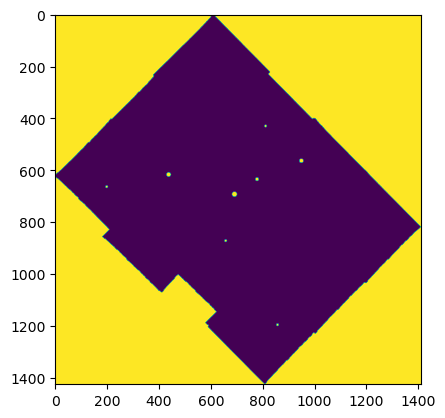

In [7]:
hdu_mask_stars = fits.open('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/muse/NGC0628_starmask.fits')[0]
mask_stars = hdu_mask_stars.data!=0
plt.imshow(mask_stars), mask_stars

In [12]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_bgsub_smoothed_regrid.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha_bgsub.fits')[0]

hdu_starmask = fits.open('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/muse/NGC0628_starmask.fits')[0]

output_filename = rootdir+'ngc628c_halpha_bgsub_fit_anchored_musegrid.fits'

data1 = hdu_input1.data
data2 = hdu_input2.data

rms = mad_std(data1, ignore_nan=True)
rms = mad_std(data1[data1<rms], ignore_nan=True)
mask_high = data1 > rms*5
mask_low = data1 > rms*3
mask1 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

rms = mad_std(data2, ignore_nan=True)
rms = mad_std(data2[data2<rms], ignore_nan=True)
mask_high = data2 > rms*20
mask_low = data2 > rms*3
mask2 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

data1[~mask1] = np.nan
data2[~mask2] = np.nan

mask_stars = hdu_starmask.data!=0
data1[mask_stars] = np.nan
data2[mask_stars] = np.nan

fits.PrimaryHDU(data1, hdu_input1.header).writeto('tmp1.fits', overwrite=True)
fits.PrimaryHDU(data2, hdu_input2.header).writeto('tmp2.fits', overwrite=True)

# plt.imshow(np.log10(data1)) 
# plt.imshow(np.log10(data2)) 

[INFO] MUSE mask lims: 214.3 348642.3
[INFO] HST mask lims: 309.0 191832.2
[INFO] xy-fit --- slope: 0.5940352218585636, intercept: -93.86710701578554
[INFO] xy-fit scaled --- slope: 0.5940352218585636, intercept: -3.683684139555485


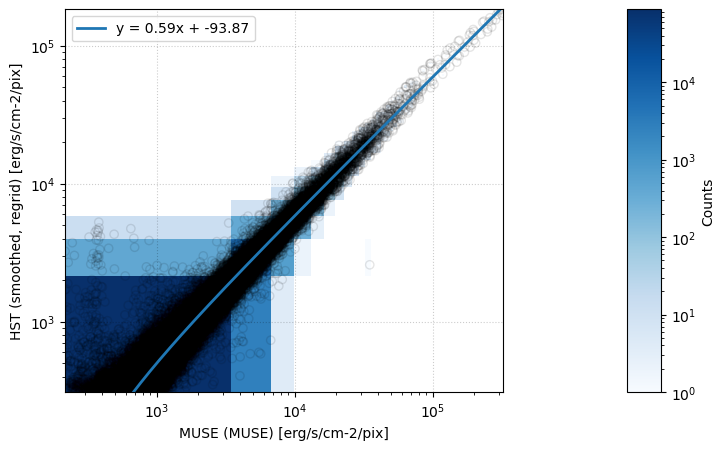

In [23]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_bgsub_smoothed_regrid.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha_bgsub.fits')[0]

hdu_starmask = fits.open('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/muse/NGC0628_starmask.fits')[0]

output_filename = rootdir+'ngc628c_halpha_bgsub_fit_anchored_musegrid.fits'

data1 = hdu_input1.data
data2 = hdu_input2.data

rms = mad_std(data1, ignore_nan=True)
rms = mad_std(data1[data1<rms], ignore_nan=True)
mask_high = data1 > rms*20
mask_low = data1 > rms*5
mask1 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

rms = mad_std(data2, ignore_nan=True)
rms = mad_std(data2[data2<rms], ignore_nan=True)
mask_high = data2 > rms*20
mask_low = data2 > rms*5
mask2 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

data1[~mask1] = np.nan
data2[~mask2] = np.nan

fits.PrimaryHDU(data1, hdu_input1.header).writeto('tmp1.fits', overwrite=True)
fits.PrimaryHDU(data2, hdu_input2.header).writeto('tmp2.fits', overwrite=True)

mask_stars = hdu_starmask.data!=0
data1[mask_stars] = np.nan
data2[mask_stars] = np.nan

valid_indices = np.isfinite(data1) & np.isfinite(data2)
x_data = data1[valid_indices]
y_data = data2[valid_indices]

xpmin = 0
ypmin = 0
xpmax = 100
ypmax = 100

x_minmask, x_maxmask = np.nanpercentile(x_data,xpmin), np.nanpercentile(x_data,xpmax)
y_minmask, y_maxmask = np.nanpercentile(y_data,ypmin), np.nanpercentile(y_data,ypmax)

# x_minmask, x_maxmask = 1e4, np.nanpercentile(x_data,xpmax)
# y_minmask, y_maxmask = 1e4, np.nanpercentile(y_data,ypmax)

print(f"[INFO] MUSE mask lims: %0.1f %0.1f" %(x_minmask, x_maxmask))
print(f"[INFO] HST mask lims: %0.1f %0.1f" %(y_minmask, y_maxmask))
x_mask = ((x_data>x_minmask) & (x_data<x_maxmask))
y_mask = ((y_data>y_minmask) & (y_data<y_maxmask))

x_data = x_data[x_mask&y_mask]
y_data = y_data[x_mask&y_mask]

# Calculate a line of best fit for the data
# w = y_data/rms
slope, intercept = np.polyfit(x_data, y_data, 1)
x_fit = np.linspace(np.min(x_data), np.max(x_data), 10000)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

hist = ax.hist2d(x_data, y_data, bins=100, cmap='Blues', norm=colors.LogNorm())
ax.scatter(x_data, y_data, ec='black', fc='none', alpha=0.1)
ax.plot(x_fit, y_fit, color='C0', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist[3], cax=cax, label='Counts')

ax.set_xlabel('MUSE (MUSE) [erg/s/cm-2/pix]')
ax.set_ylabel('HST (smoothed, regrid) [erg/s/cm-2/pix]')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

plt.tight_layout()
fig.savefig(rootdir+'fit.png', bbox_inches='tight')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
fig.savefig(rootdir+'log_fit.png', bbox_inches='tight')

# Extract the WCS information from the input and template headers
wcs_input1 = wcs.WCS(hdu_input1.header)
wcs_input3 = wcs.WCS(hdu_input3.header)
pixscale_input1 = wcs.utils.proj_plane_pixel_area(wcs_input1.celestial)
pixscale_input3 = wcs.utils.proj_plane_pixel_area(wcs_input3.celestial)

pixscale_ratio = (pixscale_input3 / pixscale_input1)
print(f"[INFO] xy-fit scaled --- slope: {slope}, intercept: {intercept*pixscale_ratio}")

hdu_fit_anchored = hdu_input3.copy()
hdu_fit_anchored.data = (hdu_fit_anchored.data - (intercept*pixscale_ratio)) / slope
hdu_fit_anchored.writeto(output_filename, overwrite=True)

[INFO] MUSE mask lims: 2.3 5.5
[INFO] HST mask lims: 2.5 5.3
[INFO] xy-fit --- slope: 1.0076874365377917, intercept: -0.30391938125387147
[INFO] xy-fit scaled --- slope: 1.0076874365377917, intercept: -0.01192689366936738


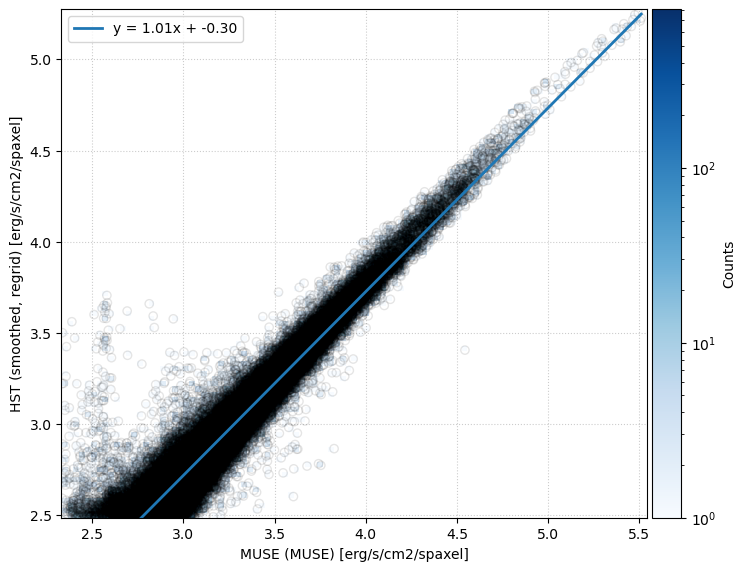

In [18]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_bgsub_smoothed_regrid.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha_bgsub.fits')[0]

hdu_starmask = fits.open('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data/ngc628/muse/NGC0628_starmask.fits')[0]

output_filename = rootdir+'ngc628c_halpha_bgsub_logfit_anchored_musegrid.fits'

data1 = hdu_input1.data
data2 = hdu_input2.data

rms = mad_std(data1, ignore_nan=True)
rms = mad_std(data1[data1<rms], ignore_nan=True)
mask_high = data1 > rms*20
mask_low = data1 > rms*5
mask1 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

rms = mad_std(data2, ignore_nan=True)
rms = mad_std(data2[data2<rms], ignore_nan=True)
mask_high = data2 > rms*20
mask_low = data2 > rms*5
mask2 = binary_dilation(mask_high, mask=mask_low, iterations=-1)

data1[~mask1] = np.nan
data2[~mask2] = np.nan

fits.PrimaryHDU(data1, hdu_input1.header).writeto('tmp1.fits', overwrite=True)
fits.PrimaryHDU(data2, hdu_input2.header).writeto('tmp2.fits', overwrite=True)

mask_stars = hdu_starmask.data!=0
data1[mask_stars] = np.nan
data2[mask_stars] = np.nan

valid_indices = np.isfinite(data1) & np.isfinite(data2)
x_data = data1[valid_indices]
y_data = data2[valid_indices]

x_data = np.log10(x_data)
y_data = np.log10(y_data)

xpmin = 0
ypmin = 0
xpmax = 100
ypmax = 100

x_minmask, x_maxmask = np.nanpercentile(x_data,xpmin), np.nanpercentile(x_data,xpmax)
y_minmask, y_maxmask = np.nanpercentile(y_data,ypmin), np.nanpercentile(y_data,ypmax)

print(f"[INFO] MUSE mask lims: %0.1f %0.1f" %(x_minmask, x_maxmask))
print(f"[INFO] HST mask lims: %0.1f %0.1f" %(y_minmask, y_maxmask))
x_mask = ((x_data>x_minmask) & (x_data<x_maxmask))
y_mask = ((y_data>y_minmask) & (y_data<y_maxmask))

x_data = x_data[x_mask&y_mask]
y_data = y_data[x_mask&y_mask]

# Calculate a line of best fit for the data
# w = y_data/rms
slope, intercept = np.polyfit(x_data, y_data, 1)
x_fit = np.linspace(np.min(x_data), np.max(x_data), 10000)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

hist = ax.hist2d(x_data, y_data, bins=100, cmap='Blues', norm=colors.LogNorm())
ax.scatter(x_data, y_data, ec='black', fc='none', alpha=0.1)
ax.plot(x_fit, y_fit, color='C0', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')

ax.set_xlim([x_minmask, x_maxmask])
ax.set_ylim([y_minmask, y_maxmask])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist[3], cax=cax, label='Counts')

ax.set_xlabel('MUSE (MUSE) [erg/s/cm2/spaxel]')
ax.set_ylabel('HST (smoothed, regrid) [erg/s/cm2/spaxel]')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

# fig.savefig(rootdir+'fit.png', bbox_inches='tight')

# ax.set_xscale('log')
# ax.set_yscale('log')

# fig.savefig(rootdir+'log_fit.png', bbox_inches='tight')

# Extract the WCS information from the input and template headers
wcs_input1 = wcs.WCS(hdu_input1.header)
wcs_input3 = wcs.WCS(hdu_input3.header)
pixscale_input1 = wcs.utils.proj_plane_pixel_area(wcs_input1.celestial)
pixscale_input3 = wcs.utils.proj_plane_pixel_area(wcs_input3.celestial)

pixscale_ratio = (pixscale_input3 / pixscale_input1)
print(f"[INFO] xy-fit scaled --- slope: {slope}, intercept: {intercept*pixscale_ratio}")

hdu_fit_anchored = hdu_input3.copy()
hdu_fit_anchored.data = (hdu_fit_anchored.data - (intercept*pixscale_ratio)) / slope
hdu_fit_anchored.writeto(output_filename, overwrite=True)

[INFO] MUSE mask lims: 1.6 226.6
[INFO] HST mask lims: -5.3 133.0
[INFO] xy-fit --- slope: 0.5670967772918774, intercept: -3.0382410283239727


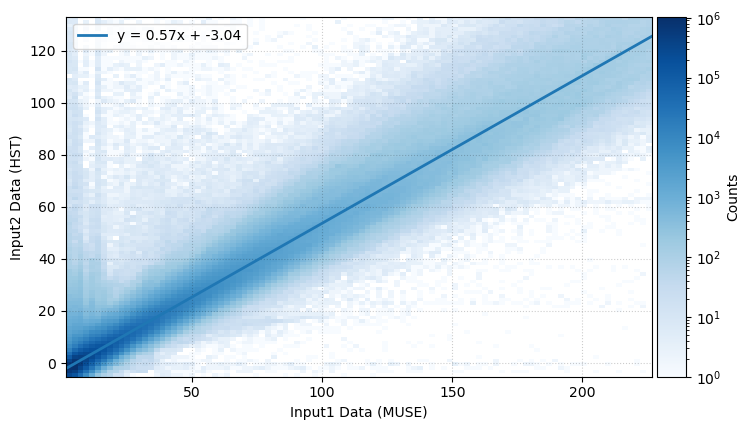

In [39]:
hdu_input1 = fits.open(rootdir+'ngc628c_musehalpha_regrid.fits')[0]
hdu_input2 = fits.open(rootdir+'ngc628c_halpha_bgsub_smoothed.fits')[0]
hdu_input3 = fits.open(rootdir+'ngc628c_halpha_bgsub.fits')[0]

output_filename = rootdir+'ngc628c_halpha_bgsub_fit_anchored_hstgrid.fits'

valid_indices = np.isfinite(hdu_input1.data) & np.isfinite(hdu_input2.data)
x_data = hdu_input1.data[valid_indices]
y_data = hdu_input2.data[valid_indices]

xpmin = 1
ypmin = 1
xpmax = 99
ypmax = 99

x_minmask, x_maxmask = np.nanpercentile(x_data,xpmin), np.nanpercentile(x_data,xpmax)
y_minmask, y_maxmask = np.nanpercentile(y_data,ypmin), np.nanpercentile(y_data,ypmax)

print(f"[INFO] MUSE mask lims: %0.1f %0.1f" %(x_minmask, x_maxmask))
print(f"[INFO] HST mask lims: %0.1f %0.1f" %(y_minmask, y_maxmask))
x_mask = ((x_data>x_minmask) & (x_data<x_maxmask))
y_mask = ((y_data>y_minmask) & (y_data<y_maxmask))

x_data = x_data[x_mask&y_mask]
y_data = y_data[x_mask&y_mask]

# Calculate a line of best fit for the data
slope, intercept = np.polyfit(x_data, y_data, 1)
x_fit = np.linspace(np.min(x_data), np.max(x_data), 100)
y_fit = slope * x_fit + intercept
print(f"[INFO] xy-fit --- slope: {slope}, intercept: {intercept}")

# Create a 2D histogram plot using the filtered data
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect('equal')

hist = ax.hist2d(x_data, y_data, bins=100, cmap='Blues', norm=colors.LogNorm())
ax.plot(x_fit, y_fit, color='C0', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hist[3], cax=cax, label='Counts')

ax.set_xlabel('Input1 Data (MUSE)')
ax.set_ylabel('Input2 Data (HST)')
ax.legend()
ax.grid(True, ls=':', color='k', alpha=0.2)

# Apply the calculated line of best fit to the second input data and save it as a new FITS file
hdu_fit_anchored = hdu_input3.copy()
hdu_fit_anchored.data = (hdu_fit_anchored.data - intercept) / slope
hdu_fit_anchored.writeto(output_filename, overwrite=True)